# Experiment 5.3: Sequence Text Classification using LSTM

## Objective:
To classify text sequences using LSTM-based models for tasks such as **sentiment analysis** or **spam detection**.



## Suggested Datasets (Use at least 10 samples):
1. IMDb Movie Reviews (Sentiment Analysis)
2. SMS Spam Collection Dataset
3. Amazon Product Reviews
4. Yelp Reviews Dataset
5. Twitter Sentiment Analysis Dataset
6. Toxic Comment Classification Dataset
7. Sarcasm Detection Dataset (News Headlines)
8. BBC News Classification Dataset
9. Disaster Tweets Classification
10. Fake News Detection Dataset



## Expected Outcome:
- Train a text classification model using an **LSTM (Long Short-Term Memory)** network.
- Evaluate the model using standard classification metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-Score
- Visualize the results using a **Confusion Matrix**.



# SMS Spam Collection Dataset

 # Import Required Libraries

In [ ]:
# Data handling and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Enable inline plotting for notebooks (remove this line if you're using a script)
%matplotlib inline

# Data preprocessing
from sklearn.model_selection import train_test_split

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Keras Sequential API for building models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dropout, Dense


# Load the Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sms+spam+collection.zip to sms+spam+collection.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("sms+spam+collection.zip", 'r') as zip_ref:
    zip_ref.extractall("SMS Spam Collection Dataset")

In [ ]:
df = pd.read_csv('/content/SMS Spam Collection Dataset/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

# Show the shape of the dataset
print("Dataset shape:", df.shape)

# Show detailed info about the dataset
print("\nDataset info:")
df.info()


Dataset shape: (5572, 2)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

# Visualize ham or spam message using wordcloud

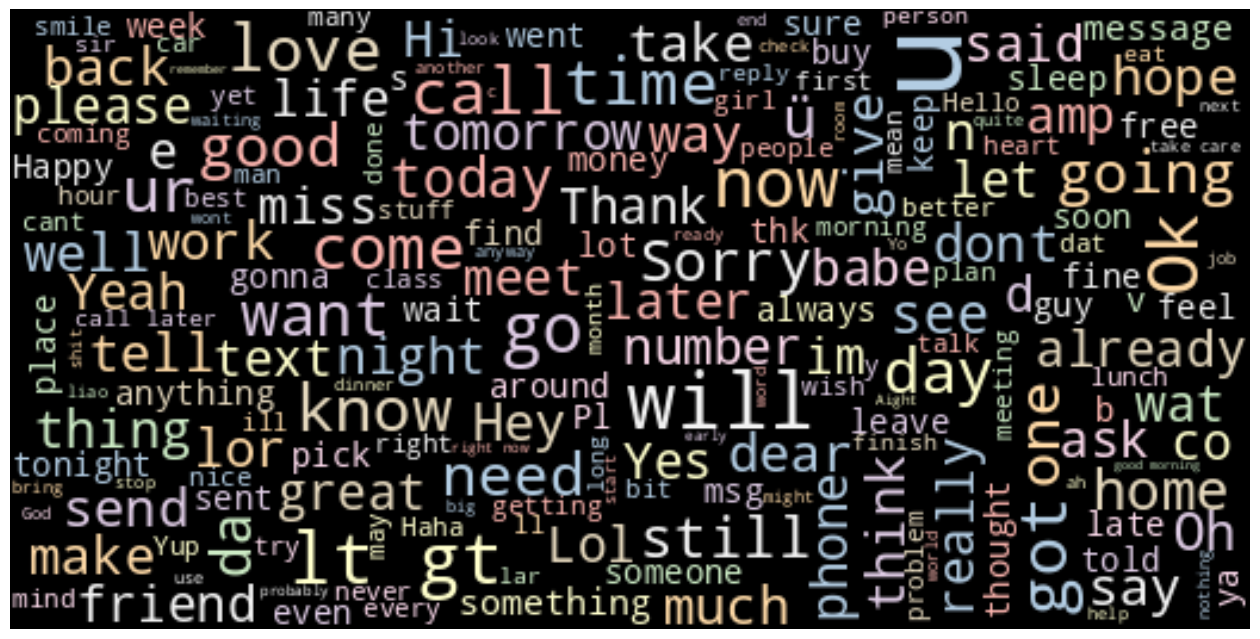

In [ ]:
# Assuming 'df' is your DataFrame with 'label' and 'message' columns
ham_msg_text = ' '.join(df[df['label'] == 'ham']['message'].astype(str).tolist())  # Filter for 'ham' messages and join them into a single string

# Check if ham_msg_text is empty and handle it
if not ham_msg_text.strip():
    print("No 'ham' messages found or they are all empty/stopwords.")
else:
    ham_msg_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50, background_color="black", colormap='Pastel1').generate(ham_msg_text)
    plt.figure(figsize=(16, 10))
    plt.imshow(ham_msg_cloud, interpolation='bilinear')
    plt.axis('off')  # turn off axis
    plt.show()

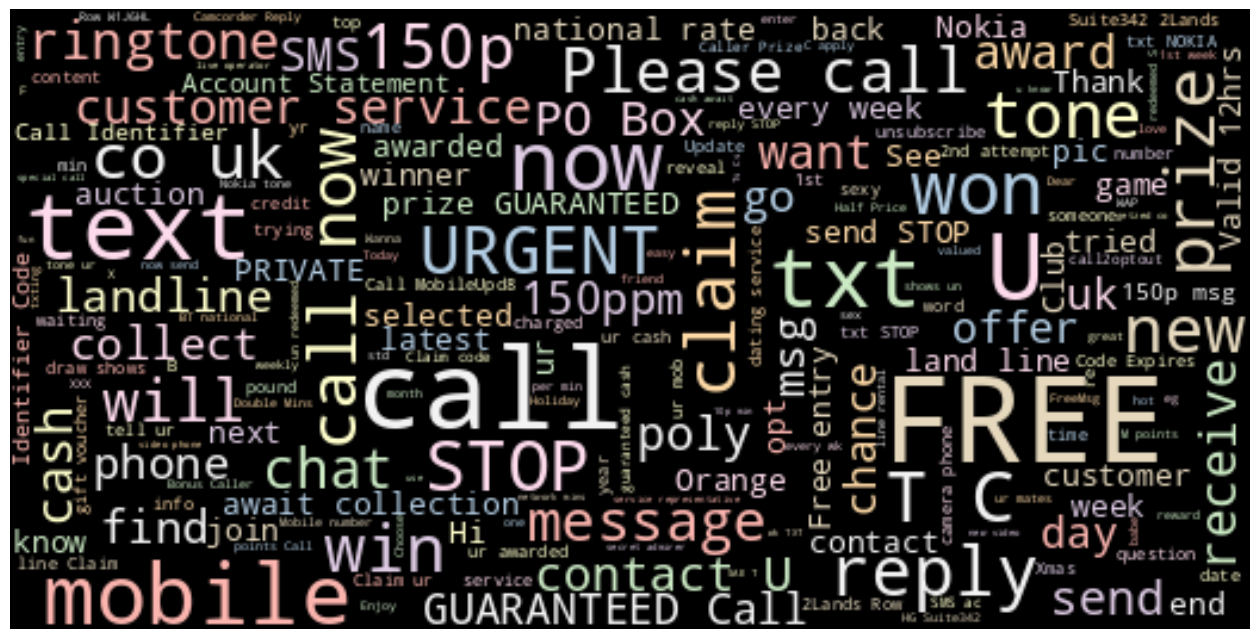

In [ ]:
# Assuming 'df' is your DataFrame with 'label' and 'message' columns
spam_msg_text = ' '.join(df[df['label'] == 'spam']['message'].astype(str).tolist())  # Filter for 'spam' messages and join them into a single string

# Now you can use spam_msg_text in the WordCloud generation
spam_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords=STOPWORDS,
                          max_font_size=50,
                          background_color ="black",
                         colormap='Pastel1').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

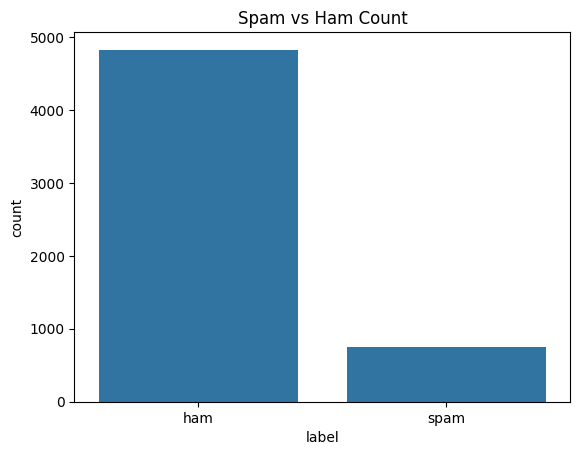

In [ ]:
sns.countplot(x='label', data=df)
plt.title("Spam vs Ham Count")
plt.show()

In [ ]:
# Filter the DataFrame for ham and spam messages
ham_msg = df[df['label'] == 'ham'] # Filter 'ham' messages
spam_msg = df[df['label'] == 'spam'] # Filter 'spam' messages

# downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

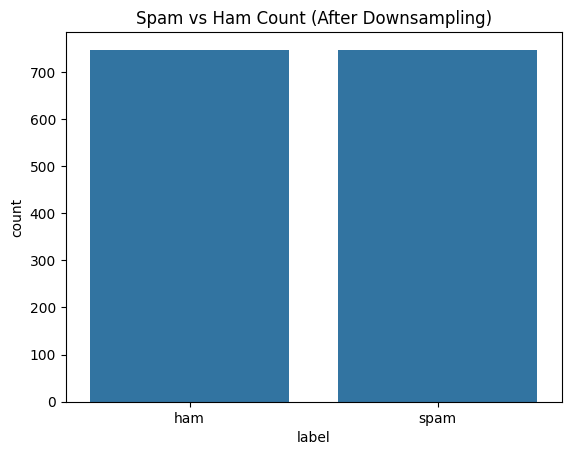

In [ ]:
# Concatenate the downsampled DataFrames
downsampled_df = pd.concat([ham_msg_df, spam_msg_df])

# Create the countplot
sns.countplot(x='label', data=downsampled_df)
plt.title("Spam vs Ham Count (After Downsampling)")
plt.show()

# Text preprocessing

Get length column for each text and convert the text label to numeric value:

In [ ]:
# Get length column for each text
downsampled_df['text_length'] = downsampled_df['message'].apply(len)

downsampled_df['msg_type'] = downsampled_df['label'].map({'ham':0, 'spam':1})
msg_label = downsampled_df['msg_type'].values
downsampled_df.head()

,label,message,text_length,msg_type
3234,ham,Height of recycling: Read twice- People spend ...,149,0
3804,ham,Yup song bro. No creative. Neva test quality. ...,74,0
2701,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to...",165,0
2820,ham,Don't forget who owns you and who's private pr...,111,0
5161,ham,Lol no. I just need to cash in my nitros. Hurr...,75,0


Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(downsampled_df['message'], msg_label, test_size=0.2, random_state=434)

Tokenization

In [ ]:
# Defining pre-processing parameters
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

Tokenizer Pre-processing Steps

The **Tokenizer** from Keras performs all the necessary pre-processing steps for text data before feeding it into a model. Here's what it does:

- **Tokenization at Word Level:** It splits the input text into words (not characters).
- **`num_words` Parameter:** Limits the vocabulary size to the top N most frequent words.
- **Punctuation Filtering:** Automatically removes common punctuation symbols.
- **Lowercase Conversion:** Converts all text to lowercase to ensure uniformity.
- **Integer Encoding:** Each word is assigned a unique integer index, used for training models.

These preprocessing steps help in creating clean and structured input data suitable for neural networks and NLP tasks.


In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

4169

Sequence and padding

data train

In [ ]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

data test:

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


# Define the LSTM model architecture:

In [ ]:
# Define parameter
n_lstm = 128
drop_lstm = 0.2
# Define LSTM Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Add this line to compile the model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model1.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_19            │ (None, 50, 16)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 128)            │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 703,109 (2.68 MB)

 Trainable params: 234,369 (915.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 468,740 (1.79 MB)

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
38/38 - 2s - 60ms/step - accuracy: 0.5431 - loss: 0.6681 - val_accuracy: 0.7726 - val_loss: 0.4860
Epoch 2/30
38/38 - 0s - 9ms/step - accuracy: 0.8820 - loss: 0.3463 - val_accuracy: 0.9064 - val_loss: 0.2667
Epoch 3/30
38/38 - 1s - 16ms/step - accuracy: 0.9397 - loss: 0.1962 - val_accuracy: 0.9097 - val_loss: 0.3109
Epoch 4/30
38/38 - 0s - 9ms/step - accuracy: 0.9473 - loss: 0.1616 - val_accuracy: 0.9264 - val_loss: 0.2133
Epoch 5/30
38/38 - 1s - 16ms/step - accuracy: 0.9573 - loss: 0.1472 - val_accuracy: 0.9164 - val_loss: 0.2526
Epoch 6/30
38/38 - 0s - 9ms/step - accuracy: 0.9607 - loss: 0.1320 - val_accuracy: 0.9465 - val_loss: 0.1537
Epoch 7/30
38/38 - 1s - 16ms/step - accuracy: 0.9749 - loss: 0.0946 - val_accuracy: 0.9431 - val_loss: 0.1219
Epoch 8/30
38/38 - 0s - 8ms/step - accuracy: 0.9732 - loss: 0.0857 - val_accuracy: 0.9431 - val_loss: 0.1641
Epoch 9/30
38/38 - 0s - 9ms/step - accuracy: 0.9757 - loss: 0.0782 - val_accuracy: 0.9398 - val_loss: 0.1504


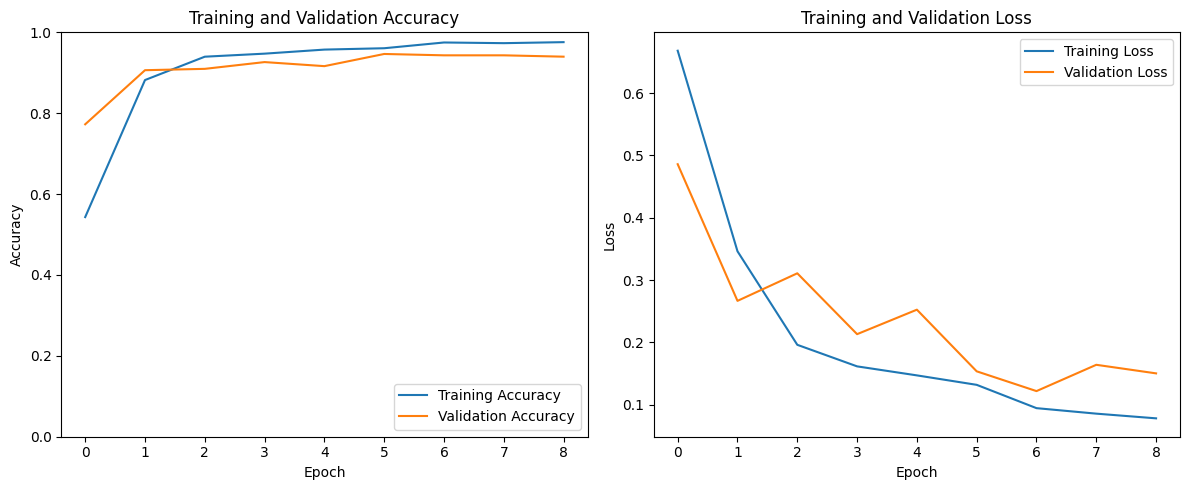

In [ ]:
# 1. Plot Accuracy Graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# 2. Plot Loss Graphs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# 3. Print Final Metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("\nFinal Training Metrics:")
print(f"Loss: {final_train_loss:.4f}")
print(f"Accuracy: {final_train_acc*100:.2f}%")

print("\nFinal Validation Metrics:")
print(f"Loss: {final_val_loss:.4f}")
print(f"Accuracy: {final_val_acc*100:.2f}%")

# 4. Format similar to your example output
print("\nFormatted Output:")
print(f"Train accuracy: {final_train_acc*100:.2f}")
print(f"Valid accuracy: {final_val_acc*100:.2f}")


Final Training Metrics:
Loss: 0.0782
Accuracy: 97.57%

Final Validation Metrics:
Loss: 0.1504
Accuracy: 93.98%

Formatted Output:
Train accuracy: 97.57
Valid accuracy: 93.98
